# Accessing ICESat-2 Data

This notebook covers ICESat-2 data query and access from the NASA NSIDC DAAC (NASA National Snow and Ice Data Center Distributed Active Archive Center). Specifically, it illustrates a recommended pathway to obtain data programmatically using the Python library `icepyx`.

#### Credits
* Notebook by: Jessica Scheick and Amy Steiker
* Source material: [NSIDC DAAC data access with icepyx](https://github.com/icesat2py/icepyx/blob/master/doc/examples/ICESat-2_DAAC_DataAccess_Example.ipynb) by Jessica Scheick


## Objectives

* Become familiar with the background, scope, and goals of the `icepyx` library.
* Learn how to interact with `icepyx` to search, order, and download subsetted ICESat-2 data.

## Motivation and Background

On Friday, we explored various options for data access and visualization. Specifically, we spent some time using OpenAltimetry to interactively discover and plot data. But now we're ready to access the data directly and conduct our own analysis on it. This calls for a programmatic way to obtain our datasets and get them into our analysis environment. Although there are many ways to do this, here we are going to show examples using `icepyx`.

`icepyx` is a wrapper on top of the NSIDC API, created to make programmatic access to ICESat-2 data easier. The library is open-source, community developed and driven, and was created in response to user challenges faced at the 2019 ICESat-2 Cryosphere-themed Hackweek. Under continuous development, we think you'll find `icepyx` a useful resource and encourage you to contribute your ideas, code, and feedback to enhance its use throughout the entire ICESat-2 workflow as depicted below. We hope that this year's Hackweek expands our ICESat-2 data-user community and sparks future feature development, both through hacking projects and beyond.

**Please note that the tutorials presented here used version 0.2.0 of `icepyx`. These tutorials are set up to use that version in the provided Binder link, but they will not run without edits on more recent versions (>= v0.3.0) of `icepyx` due to non-backwards compatible changes in syntax. Similar, up-to-date data access tutorials/examples are available [from `icepyx`](https://icepyx.readthedocs.io/en/latest/getting_started/example_link.html).**

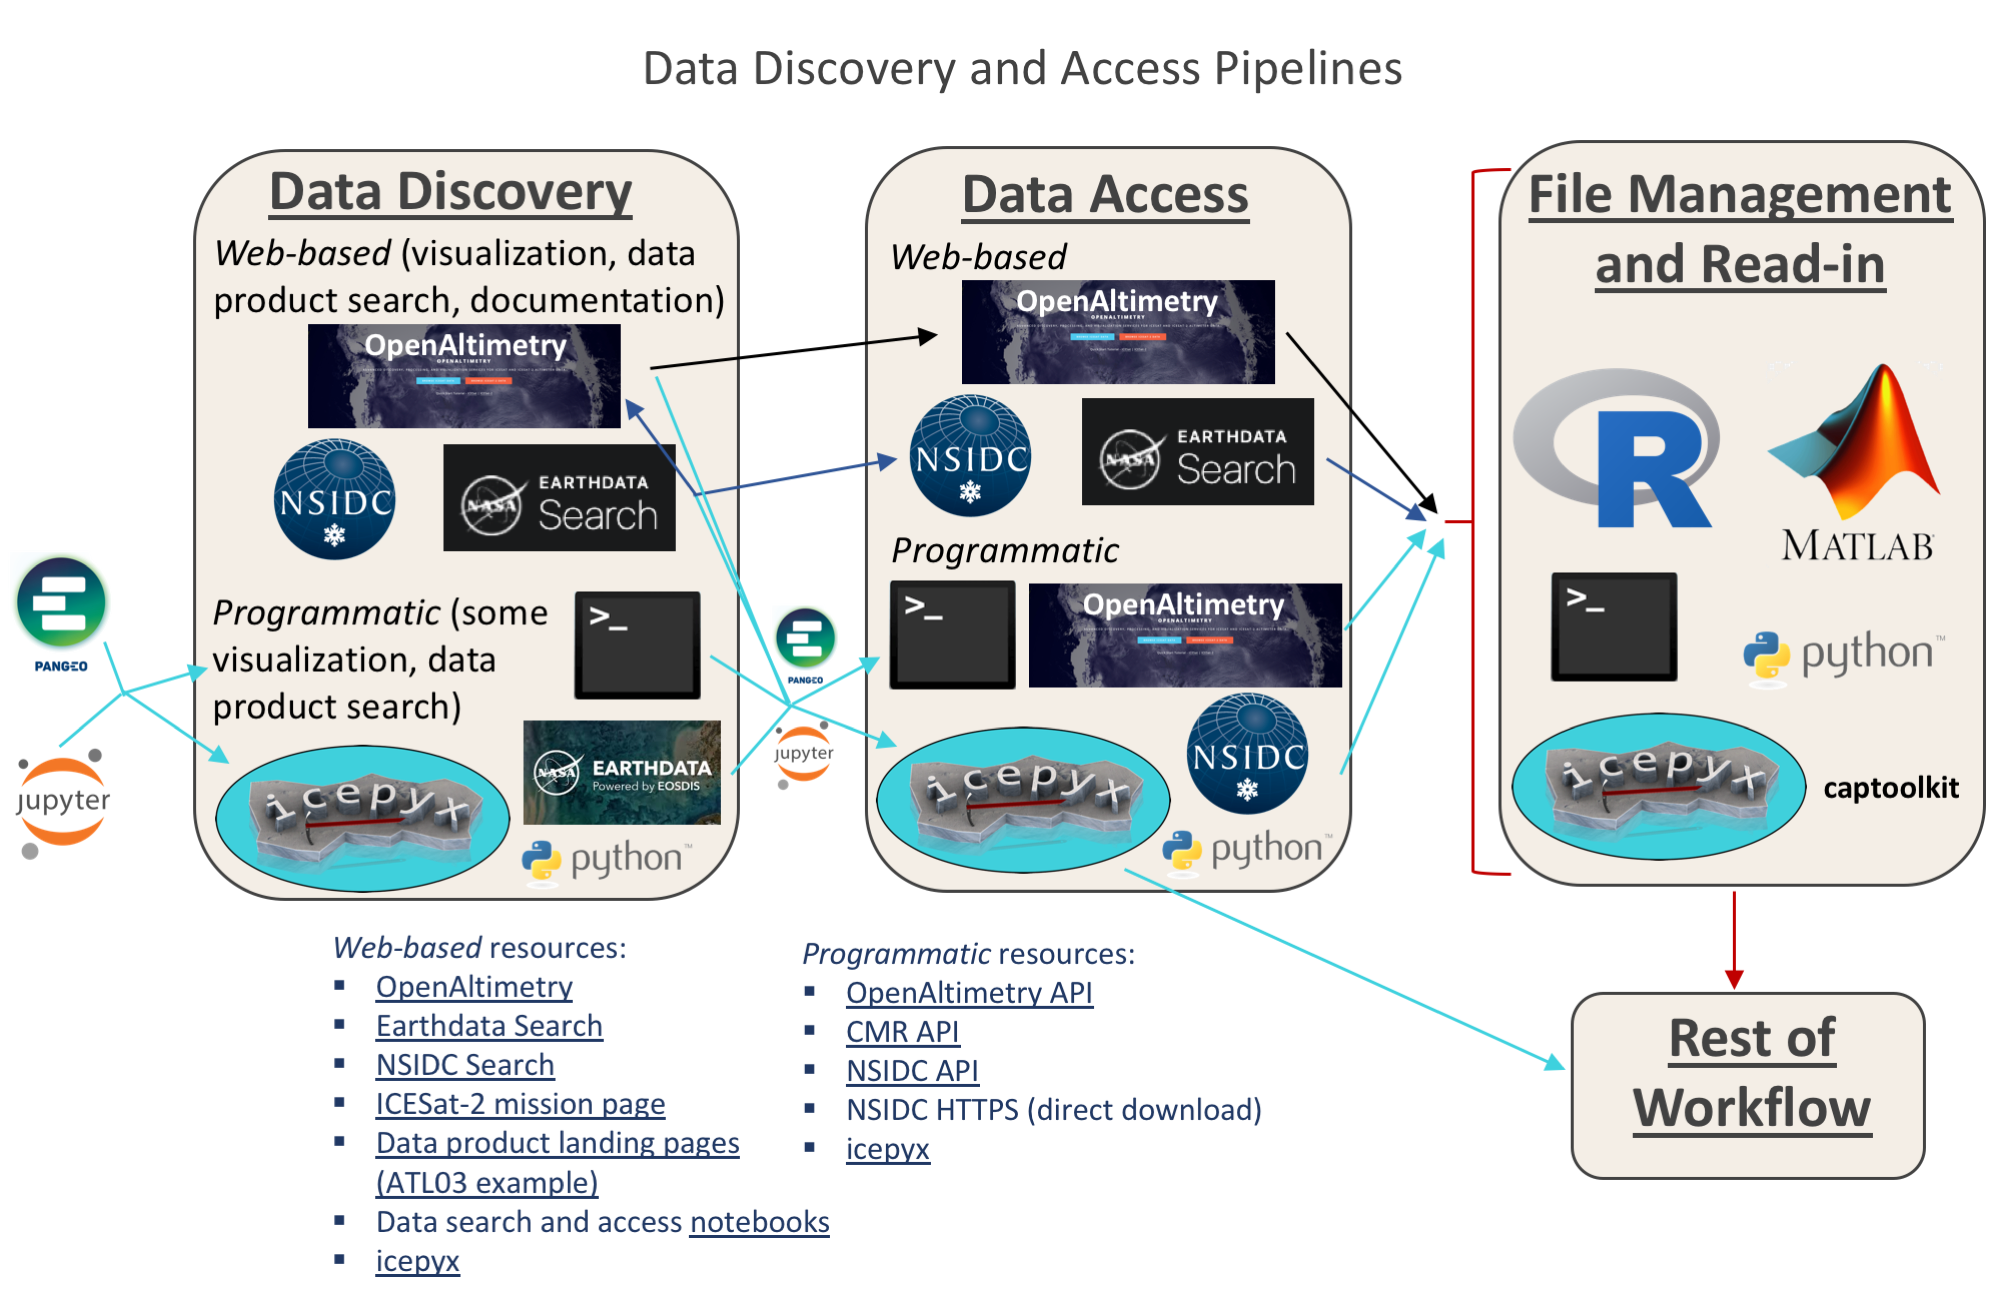

In [1]:
img_path= './supporting_docs/IS2_data_access_options_d3.png'
from IPython.display import Image
Image(img_path) 


## NSIDC DAAC Programmatic Data Access using icepyx

### Import packages, including icepyx

In [2]:
from icepyx import icesat2data as ipd
import os
import shutil
from pprint import pprint
%matplotlib inline

### Key Steps for Programmatic Data Access

There are several key steps for accessing data from the NSIDC API:
1. Define your parameters (spatial, temporal, dataset, etc.)
2. Query the NSIDC API to find out more information about the dataset
3. Log in to NASA Earthdata
4. Define additional parameters (e.g. subsetting/customization options)
5. Order your data
6. Download your data

We'll go through each of these steps during this tutorial, at the end summarizing how `icepyx` streamlines this process into a minimal number of lines of code.

------------------
------------------
### Step 1: Create an ICESat-2 data object with the desired search parameters

There are three required inputs:
- `short_name` = the dataset of interest, known as its "short name".
See https://nsidc.org/data/icesat-2/data-sets for a list of the available datasets. Dataset shortnames, or IDs, can also be found at the top of each individual dataset landing page on NSIDC's website.

- `spatial extent` = a region of interest to search within. This can be entered as a bounding box, polygon vertex coordinate pairs, or a polygon geospatial file (currently shp, kml, and gpkg are supported, though gpkg is still untested).
    - Bounding box: Given in decimal degrees for the lower left longitude, lower left latitude, upper right longitude, and upper right latitude. West longitudes and south latitudes should be provided as negative degrees.
    - Polygon vertices: Given as longitude, latitude coordinate pairs of decimal degrees with the last entry a repeat of the first.
    - Polygon file: A string containing the full file path and name.


- `date_range` = the date range for which you would like to search for results. Must be formatted as a set of 'YYYY-MM-DD' strings separated by comma. 

There are also several optional inputs to allow the user finer control over their search.
- `start_time` = start time to search for data on the start date. If no input is given, this defaults to 00:00:00.
- `end_time` = end time for the end date of the temporal search parameter. If no input is given, this defaults to 23:59:59. Times must be input as 'HH:mm:ss' strings.
- `version` = What version of the dataset to use, input as a numerical string. If no input is given, this value defaults to the most recent version of the dataset specified in `short_name`.

*IMPORTANT NOTES* 

- **Spatial extents:** The spatial extent is a required input for data access. Much like how your spatial extent in OpenAltimetry showed which tracks were available, this input provides an easy way for the NSIDC API to search through the ICESat-2 metadata and determine which granules *might* have some coverage there (without having to open all the individual granules, which would take a lot of computing resources). Then, this same spatial region will be used a second time to actually extract the data for the region you're interested in (which is why you might get a message during ordering saying a given granule didn't have any data in your region of interest). See Figure 1 in the [NSIDC Programmatic Access Guide](https://nsidc.org/support/how/how-do-i-programmatically-request-data-services) to view an example of the concept of spatial filtering (granules overlapping the inputted spatial extent based on the granule metadata), and spatial subsetting (data values within each granule are cropped, or extracted, based on the inputted spatial extent). 

- **Version warnings:** Version 001 is used as an example in the below cell to illustrate the warning issued by not using the most recent version. However, using it will cause 'no results' errors in granule ordering for some search parameters. These issues have been resolved in later versions of the datasets, so it is best to use the most recent version where possible. We will re-initialize `region_a` in a later cell to use for the rest of this notebook.

Below is an example using a spatial extent over Pine Island Glacier that was used as the same input for the land ice tutorial during this Hackweek.

In [3]:
# Pine Island Glacier
short_name = 'ATL06'
spatial_extent = [-102, -76, -98, -74.5]
date_range = ['2019-06-18','2019-06-25']

Create the data object using our inputs. Note the version warning if we specify an old version.

In [4]:
region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range, \
                           start_time='03:30:00', end_time='21:30:00', version='001')

print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.spatial_extent)

ATL06
['2019-06-18', '2019-06-25']
03:30:00
21:30:00
001
['bounding box', [-102, -76, -98, -74.5]]


/srv/conda/envs/notebook/lib/python3.7/site-packages/icepyx/core/validate_inputs.py:25: UserWarning: You are using an old version of this dataset
  warnings.warn("You are using an old version of this dataset")


Now re-populate the data object. Note that with no version or time specified, the defaults are used.

In [5]:
region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range)

Formatted parameters and function calls allow us to see the the properties of the data object we have created.

In [6]:
print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.spatial_extent)

ATL06
['2019-06-18', '2019-06-25']
00:00:00
23:59:59
003
['bounding box', [-102, -76, -98, -74.5]]


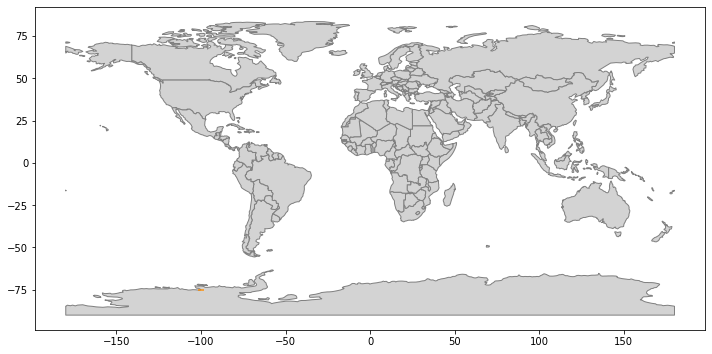

In [7]:
region_a.visualize_spatial_extent()

Alternatively, you could also just create the data object without creating named variables first:

In [8]:
# region_a = ipd.Icesat2Data('ATL06',[-102, -76, -98, -74.5],['2019-06-18', '2019-06-25'], \
#                            start_time='00:00:00', end_time='23:59:59', version='003')

#### Built in methods allow us to get more information about our dataset
In addition to viewing the stored object information shown above (e.g. dataset, start and end date and time, version, etc.), we can also request summary information about the dataset itself or confirm that we have manually specified the latest version.

In [9]:
print(region_a.latest_version())
region_a.dataset_summary_info()

003
dataset_id :  ATLAS/ICESat-2 L3A Land Ice Height V003
short_name :  ATL06
version_id :  003
time_start :  2018-10-14T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  This data set (ATL06) provides geolocated, land-ice surface heights (above the WGS 84 ellipsoid, ITRF2014 reference frame), plus ancillary parameters that can be used to interpret and assess the quality of the height estimates. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '96.8', 'inclination_angle': '92.0', 'number_of_orbits': '0.071428571', 'start_circular_latitude': '0.0'}


If the summary does not provide all of the information you are looking for, or you would like to see information for previous versions of the dataset, all available metadata for the collection dataset is available in a readable format.

In [10]:
region_a.dataset_all_info()

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V002',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1631076765-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.002/',
                                'hreflang': 'en-US',
 

------------------
------------------
### Step 2: Querying a dataset
In order to search the dataset collection for available data granules, we need to build our search parameters. This is done automatically behind the scenes when you run `region_a.avail_granules()`, but you can also build and view them by calling `region_a.CMRparams`. These are formatted as a dictionary of key:value pairs according to the CMR documentation.

***What is CMR?***

*The Common Metadata Repository (CMR) is a high-performance, high-quality, continuously evolving metadata system that catalogs Earth Science data and associated service metadata records. These metadata records are registered, modified, discovered, and accessed through programmatic interfaces leveraging standard protocols and APIs. Note that not all NSIDC data can be searched at the file level using CMR, particularly those outside of the NASA DAAC program.*

*CMR API documentation: https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html*

***What are granules?***

*'Granules' are essentially data files with specific bounds. You can think of a granule as a snapshot in space and time, where each granule is stored in an individual file. In order to cover a large geographic area or have multiple snapshots in time, you would need to combine (mosaic) and/or compare multiple granules/files worth of data. Data storage and access using some of the other formats and tools described throughout this Hackweek (`Zarr`, `XArray`, `Dask`) are specifically designed to alleviate the problems introduced to cloud and parallel computing by virtue of the data being stored in granule/file-type pieces.*

In [11]:
#build and view the parameters that will be submitted in our query
region_a.CMRparams

{'short_name': 'ATL06',
 'version': '003',
 'temporal': '2019-06-18T00:00:00Z,2019-06-25T23:59:59Z',
 'bounding_box': '-102,-76,-98,-74.5'}

Now that our parameter dictionary is constructed, we can search the CMR database for the available granules. Granules returned by the CMR metadata search are automatically stored within the data object. Recall the search completed at this level relies completely on the granules' metadata. As a result, some (and in rare cases all) of the granules returned may not actually contain data in your specified region, particularly if the region is small or located near the boundaries of a given granule. If this is the case, the subsetter will not return any data when you actually place the order. A warning message will be issued during ordering for each granule to which this applies (but no message is output for successfully subsetted granules, so don't worry!)

In [12]:
#search for available granules and provide basic summary info about them
region_a.avail_granules()

{'Number of available granules': 4,
 'Average size of granules (MB)': 25.473045825950003,
 'Total size of all granules (MB)': 101.89218330380001}

In [13]:
#get a list of the available granule IDs that meet your search criteria
region_a.avail_granules(ids=True)

['ATL06_20190621104104_12850312_003_01.h5',
 'ATL06_20190621212741_12920310_003_01.h5',
 'ATL06_20190625103243_13460312_003_01.h5',
 'ATL06_20190625211921_13530310_003_01.h5']

In [14]:
#print detailed information about the returned search results
region_a.granules.avail

[{'producer_granule_id': 'ATL06_20190621104104_12850312_003_01.h5',
  'time_start': '2019-06-21T10:41:04.000Z',
  'orbit': {'ascending_crossing': '-87.33645139516301',
   'start_lat': '-79',
   'start_direction': 'A',
   'end_lat': '-50',
   'end_direction': 'A'},
  'updated': '2020-05-04T15:38:15.464Z',
  'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2019-06-21T09:27:32.063Z',
    'equator_crossing_longitude': '-87.33645139516301',
    'orbit_number': '4260'}],
  'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V003',
  'data_center': 'NSIDC_ECS',
  'title': 'SC:ATL06.003:178123773',
  'coordinate_system': 'ORBIT',
  'time_end': '2019-06-21T10:43:05.000Z',
  'id': 'G1726150688-NSIDC_ECS',
  'original_format': 'ISO-SMAP',
  'granule_size': '9.003663063',
  'browse_flag': True,
  'polygons': [['-86.07299178270124 -77.85411016875652 -78.87842069816162 -96.84437563950479 -78.8199631554495 -95.19678780002275 -85.91124292908752 -73.83688618812428 -86.07299178270124 -

------------------
------------------
### Step 3: Log in to NASA Earthdata

In order to download any data from NSIDC, we must first authenticate ourselves using a valid Earthdata login. This will start an active logged-in session to enable data download. Once you have successfully logged in for a given icesat2data instance, the session will be passed behind the scenes as needed for you to order and download data. Passwords are entered but not shown or stored in plain text by the system.

In [ ]:
# Fill this in with your Earthdata Login user name and associated email

earthdata_uid = ''
email = ''
region_a.earthdata_login(earthdata_uid, email)

In [16]:
# icepyx development login

earthdata_uid = 'icepyx_devteam'
email = 'icepyx.dev@gmail.com'
region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password:  ·········


------------------
------------------
### Step 4: Additional Parameters and Subsetting

Once we have generated our session, we must build the required configuration parameters needed to actually download data. These will tell the system how we want to download the data. As with the CMR search parameters, these will be built automatically when you run `region_a.order_granules()`, but you can also create and view them with `region_a.reqparams`. The default parameters, given below, should work for most users.
- `page_size` = 10. This is the number of granules we will request per order.
- `page_num` = 1. Determine the number of pages based on page size and the number of granules available. If no page_num is specified, this calculation is done automatically to set page_num, which then provides the number of individual orders we will request given the number of granules.
- `request_mode` = 'async'
- `agent` = 'NO'
- `include_meta` = 'Y'

#### More details about the **configuration parameters**
`request_mode` is "asynchronous" by default, which allows concurrent requests to be queued and processed without the need for a continuous connection. In contrast, using a "synchronous" `request_mode` means that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed", to your working directory. For this tutorial, we will set the request mode to asynchronous.

**Use the streaming `request_mode` with caution: While it can be beneficial to stream outputs directly to your local directory, note that timeout errors can result depending on the size of the request, and your request will not be queued in the system if NSIDC is experiencing high request volume. For best performance, NSIDC recommends setting `page_size=1` to download individual outputs, which will eliminate extra time needed to zip outputs and will ensure faster processing times per request.**


Recall that we queried the total number and volume of granules prior to applying customization services. `page_size` and `page_num` can be used to adjust the number of granules per request up to a limit of 2000 granules for asynchronous, and 100 granules for synchronous (streaming). For now, let's select 9 granules to be processed in each zipped request. For ATL06, the granule size can exceed 100 MB so we want to choose a granule count that provides us with a reasonable zipped download size. 

In [17]:
print(region_a.reqparams)

{'page_size': 10, 'page_num': 1}


#### **Subsetting**

Note: The rest of this section will provide a very cursory overview of subsetting (what it is, how to subset in icepyx, common questions/issues). For a deeper dive into subsetting, please see our [Subsetting Tutorial Notebook](https://github.com/ICESAT-2HackWeek/data-access/blob/master/notebooks/03-Data_Access2_Subsetting.ipynb), which covers subsetting in more detail, including how to get a list of subsetting options, how to build your list of subsetting parameters, and how to generate a list of desired variables (most datasets have more than 200 variable fields!), including using pre-built default lists (these lists are still in progress and we welcome contributions!).

***What is SUBSETTING anyway?***

*Anyone who's worked with geospatial data has probably encountered subsetting. Typically, we search for data wherever it is stored and download the chunks (aka granules, scenes, passes, swaths, etc.) that contain something we are interested in. Then, we have to extract from each chunk the pieces we actually want to analyze. Those pieces might be geospatial (i.e. an area of interest), temporal (i.e. certain months of a time series), and/or certain variables. This process of extracting the data we are going to use is called subsetting. See Figure 1 in the [NSIDC Programmatic Access Guide](https://nsidc.org/support/how/how-do-i-programmatically-request-data-services) for an illustration of this behavior.*

*In the case of ICESat-2 data coming from the NSIDC DAAC, we can do this subsetting step on the data prior to download, reducing our number of data processing steps and resulting in smaller, faster downloads and storage.*

In addition to the required parameters (CMRparams and reqparams) that are submitted with our order, for ICESat-2 datasets we can also submit subsetting and reformatting parameters to NSIDC. This utilizes the NSIDC's built in subsetter to extract only the data you are interested (spatially, temporally, variables of interest, etc.). The advantages of using the NSIDC's subsetter include:
* easily reproducible downloads, particularly when coupled with an icepyx data object
* smaller file size, meaning faster downloads, less storage required, and no need to subset the data on your own
* still easy to go back and order more data/variables with the same or similar search parameters
* no extraneous data means you can move directly to analysis and easily navigate your dataset


Certain subset parameters are specified by default unless `subset=False` is included as an input to `order_granules()` or `download_granules()` (which calls `order_granules()` under the hood).

As for the CMR and required parameters, default subset parameters can be built and viewed using `subsetparams`. Where an input spatial file is used, rather than a bounding box or manually entered polygon, the spatial file will be used for subsetting (unless subset is set to False) but not show up in the `subsetparams` dictionary.

`icepyx` also makes it easy to take advantage of the reformatting (e.g. file format conversion) options offered by NSIDC. These are covered in more detail in the [Subsetting Tutorial Notebook](https://github.com/ICESAT-2HackWeek/data-access/blob/master/notebooks/03-Data_Access2_Subsetting.ipynb).

In [18]:
region_a.subsetparams()

{'time': '2019-06-18T00:00:00,2019-06-25T23:59:59',
 'bbox': '-102,-76,-98,-74.5'}

##### Discover Subsetting Options

You can see what subsetting options are available for a given dataset by calling `show_custom_options()`. The options are presented as a series of headings followed by available values in square brackets. Headings are:
* **Subsetting Options**: whether or not temporal and spatial subsetting are available for the dataset
* **Data File Formats (Reformatting Options)**: return the data in a format other than the native hdf5 (submitted as a key=value kwarg to `order_granules(format='NetCDF4-CF')`)
* **Data File (Reformatting) Options Supporting Reprojection**: return the data in a reprojected reference frame. These options will be supported in the future for gridded ICESat-2 L3B datasets, once those are produced and made available.
* **Data File (Reformatting) Options NOT Supporting Reprojection**: data file formats that cannot be delivered with reprojection
* **Data Variables (also Subsettable)**: a dictionary of variable name keys and the paths to those variables available in the dataset

In [19]:
region_a.show_custom_options(dictview=True)

Subsetting options
[{'id': 'ICESAT2',
  'maxGransAsyncRequest': '2000',
  'maxGransSyncRequest': '100',
  'spatialSubsetting': 'true',
  'spatialSubsettingShapefile': 'true',
  'temporalSubsetting': 'true',
  'type': 'both'}]
Data File Formats (Reformatting Options)
['TABULAR_ASCII', 'NetCDF4-CF', 'Shapefile', 'NetCDF-3']
Reprojection Options
[]
Data File (Reformatting) Options Supporting Reprojection
['TABULAR_ASCII', 'NetCDF4-CF', 'Shapefile', 'NetCDF-3', 'No reformatting']
Data File (Reformatting) Options NOT Supporting Reprojection
[]
Data Variables (also Subsettable)
{'atl06_quality_summary': ['gt1l/land_ice_segments/atl06_quality_summary',
                           'gt1r/land_ice_segments/atl06_quality_summary',
                           'gt2l/land_ice_segments/atl06_quality_summary',
                           'gt2r/land_ice_segments/atl06_quality_summary',
                           'gt3l/land_ice_segments/atl06_quality_summary',
                           'gt3r/land_ice_segm

##### About Data Variables in an Icesat2Data object
Each `icesat2data` object has an associated `order_vars` parameter, which is for interacting with variables during data querying, ordering, and downloading activities. `order_vars.wanted` holds the user's list to be submitted to the NSIDC subsetter and download a smaller, reproducible dataset

Each variables parameter has methods to:
* get variables available from the NSIDC (`avail()` method/attribute).
* append new variables to the wanted list (`append()` method).
* remove variables from the wanted list (`remove()` method).

###### Determine what variables are available
There are multiple ways to get a complete list of available variables.

1. `region_a.order_vars.avail`, a list of all valid path+variable strings
2. `region_a.show_custom_options(dictview=True)`, all available subsetting and data transformation options, as you ran above
3. `region_a.order_vars.parse_var_list(region_a.order_vars.avail)`, a dictionary of variable:paths key:value pairs

By passing the boolean `options=True` to the `avail` method, you can obtain lists of unique possible variable inputs (var_list inputs) and path subdirectory inputs (keyword_list and beam_list inputs) for your dataset. These can be helpful for building your wanted variable list.

In [20]:
region_a.order_vars.avail(options=True)

var_list inputs: atlas_sdp_gps_epoch, control, data_end_utc, data_start_utc, end_cycle, end_delta_time, end_geoseg, end_gpssow, end_gpsweek, end_orbit, end_region, end_rgt, granule_end_utc, granule_start_utc, qa_at_interval, release, start_cycle, start_delta_time, start_geoseg, start_gpssow, start_gpsweek, start_orbit, start_region, start_rgt, version, dt_hist, fit_maxiter, fpb_maxiter, maxiter, max_res_ids, min_dist, min_gain_th, min_n_pe, min_n_sel, min_signal_conf, n_hist, nhist_bins, n_sigmas, proc_interval, qs_lim_bsc, qs_lim_hrs, qs_lim_hsigma, qs_lim_msw, qs_lim_snr, qs_lim_sss, rbin_width, sigma_beam, sigma_tx, t_dead, atl06_quality_summary, delta_time, h_li, h_li_sigma, latitude, longitude, segment_id, sigma_geo_h, fpb_mean_corr, fpb_mean_corr_sigma, fpb_med_corr, fpb_med_corr_sigma, fpb_n_corr, med_r_fit, tx_mean_corr, tx_med_corr, dem_flag, dem_h, geoid_h, dh_fit_dx, dh_fit_dx_sigma, dh_fit_dy, h_expected_rms, h_mean, h_rms_misfit, h_robust_sprd, n_fit_photons, n_seg_pulses,

###### Modifying your wanted variable list

Generating and modifying your variable request list, which is stored in `region_a.order_vars.wanted`, is controlled by the `append` and `remove` functions that operate on `region_a.order_vars.wanted`. The input options to `append` are as follows (the full documentation for this function can be found by executing `help(region_a.order_vars.append)`).
* `defaults` (default False) - include the default variable list for your dataset (not yet fully implemented for all datasets; please submit your default variable list for inclusion!)
* `var_list` (default None) - list of variables (entered as strings)
* `beam_list` (default None) - list of beams/profiles (entered as strings)
* `keyword_list` (default None) - list of keywords (entered as strings); use `keyword_list=['']` to obtain a list of available keywords

Similarly, the options for `remove` are:
* `all` (default False) - reset `region_a.order_vars.wanted` to None
* `var_list` (as above)
* `beam_list` (as above)
* `keyword_list` (as above)

A few brief examples of this functionality are below. Please see the [Subsetting Tutorial Notebook](https://github.com/ICESAT-2HackWeek/data-access/blob/master/notebooks/03-Data_Access2_Subsetting.ipynb) for a more thorough set of examples for both beam and profile datasets.

**Example 1: create a default variable list**

In [21]:
region_a.order_vars.append(defaults=True)
pprint(region_a.order_vars.wanted)

{'atl06_quality_summary': ['gt1l/land_ice_segments/atl06_quality_summary',
                           'gt1r/land_ice_segments/atl06_quality_summary',
                           'gt2l/land_ice_segments/atl06_quality_summary',
                           'gt2r/land_ice_segments/atl06_quality_summary',
                           'gt3l/land_ice_segments/atl06_quality_summary',
                           'gt3r/land_ice_segments/atl06_quality_summary'],
 'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'],
 'bsnow_conf': ['gt1l/land_ice_segments/geophysical/bsnow_conf',
                'gt1r/land_ice_segments/geophysical/bsnow_conf',
                'gt2l/land_ice_segments/geophysical/bsnow_conf',
                'gt2r/land_ice_segments/geophysical/bsnow_conf',
                'gt3l/land_ice_segments/geophysical/bsnow_conf',
                'gt3r/land_ice_segments/geophysical/bsnow_conf'],
 'bsnow_h': ['gt1l/land_ice_segments/geophysical/bsnow_h',
             'gt1r/land_ice_segment

**Example 2: clear the variable list**

In [22]:
region_a.order_vars.remove(all=True)
pprint(region_a.order_vars.wanted)

None


**Example 3: choose variables**

Add all `latitude` variables across all six beam groups. Note that the additional required variables for time and spacecraft orientation are included by default.

In [23]:
region_a.order_vars.append(var_list=['latitude'])
pprint(region_a.order_vars.wanted)

{'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'],
 'data_end_utc': ['ancillary_data/data_end_utc'],
 'data_start_utc': ['ancillary_data/data_start_utc'],
 'end_delta_time': ['ancillary_data/end_delta_time'],
 'granule_end_utc': ['ancillary_data/granule_end_utc'],
 'granule_start_utc': ['ancillary_data/granule_start_utc'],
 'latitude': ['gt1l/land_ice_segments/latitude',
              'gt1r/land_ice_segments/latitude',
              'gt2l/land_ice_segments/latitude',
              'gt2r/land_ice_segments/latitude',
              'gt3l/land_ice_segments/latitude',
              'gt3r/land_ice_segments/latitude'],
 'sc_orient': ['orbit_info/sc_orient'],
 'sc_orient_time': ['orbit_info/sc_orient_time'],
 'start_delta_time': ['ancillary_data/start_delta_time']}


**Example 4: add/remove selected beams+variables**

Add `longitude` for beams `gt1l` and `gt3l` and remove `latitude` for beam `gt2l`

In [24]:
region_a.order_vars.append(beam_list=['gt1l', 'gt3l'],var_list=['longitude'])
region_a.order_vars.remove(beam_list=['gt2l'], var_list=['latitude'])
pprint(region_a.order_vars.wanted)

{'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'],
 'data_end_utc': ['ancillary_data/data_end_utc'],
 'data_start_utc': ['ancillary_data/data_start_utc'],
 'end_delta_time': ['ancillary_data/end_delta_time'],
 'granule_end_utc': ['ancillary_data/granule_end_utc'],
 'granule_start_utc': ['ancillary_data/granule_start_utc'],
 'latitude': ['gt1l/land_ice_segments/latitude',
              'gt1r/land_ice_segments/latitude',
              'gt2r/land_ice_segments/latitude',
              'gt3l/land_ice_segments/latitude',
              'gt3r/land_ice_segments/latitude'],
 'longitude': ['gt1l/land_ice_segments/longitude',
               'gt3l/land_ice_segments/longitude'],
 'sc_orient': ['orbit_info/sc_orient'],
 'sc_orient_time': ['orbit_info/sc_orient_time'],
 'start_delta_time': ['ancillary_data/start_delta_time']}


**Example 5: use default variables for order download**

In [25]:
region_a.order_vars.remove(all=True)
region_a.order_vars.append(defaults=True)
pprint(region_a.order_vars.wanted)

{'atl06_quality_summary': ['gt1l/land_ice_segments/atl06_quality_summary',
                           'gt1r/land_ice_segments/atl06_quality_summary',
                           'gt2l/land_ice_segments/atl06_quality_summary',
                           'gt2r/land_ice_segments/atl06_quality_summary',
                           'gt3l/land_ice_segments/atl06_quality_summary',
                           'gt3r/land_ice_segments/atl06_quality_summary'],
 'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'],
 'bsnow_conf': ['gt1l/land_ice_segments/geophysical/bsnow_conf',
                'gt1r/land_ice_segments/geophysical/bsnow_conf',
                'gt2l/land_ice_segments/geophysical/bsnow_conf',
                'gt2r/land_ice_segments/geophysical/bsnow_conf',
                'gt3l/land_ice_segments/geophysical/bsnow_conf',
                'gt3r/land_ice_segments/geophysical/bsnow_conf'],
 'bsnow_h': ['gt1l/land_ice_segments/geophysical/bsnow_h',
             'gt1r/land_ice_segment

##### Applying variable subsetting to your order and download

In order to have your wanted variable list included with your order, you must pass it as a keyword argument to the `subsetparams()` attribute (next cell block) or the `order_granules()` or `download_granules()` (Steps 4 and 5, below). 

In [26]:
region_a.subsetparams(Coverage=region_a.order_vars.wanted)

{'time': '2019-06-18T00:00:00,2019-06-25T23:59:59',
 'bbox': '-102,-76,-98,-74.5',
 'Coverage': '/orbit_info/sc_orient,/orbit_info/sc_orient_time,/ancillary_data/atlas_sdp_gps_epoch,/ancillary_data/data_start_utc,/ancillary_data/data_end_utc,/ancillary_data/granule_start_utc,/ancillary_data/granule_end_utc,/ancillary_data/start_delta_time,/ancillary_data/end_delta_time,/gt1l/land_ice_segments/delta_time,/gt1l/residual_histogram/delta_time,/gt1l/segment_quality/delta_time,/gt1r/land_ice_segments/delta_time,/gt1r/residual_histogram/delta_time,/gt1r/segment_quality/delta_time,/gt2l/land_ice_segments/delta_time,/gt2l/residual_histogram/delta_time,/gt2l/segment_quality/delta_time,/gt2r/land_ice_segments/delta_time,/gt2r/residual_histogram/delta_time,/gt2r/segment_quality/delta_time,/gt3l/land_ice_segments/delta_time,/gt3l/residual_histogram/delta_time,/gt3l/segment_quality/delta_time,/gt3r/land_ice_segments/delta_time,/gt3r/residual_histogram/delta_time,/gt3r/segment_quality/delta_time,/qua

------------------
------------------
### Step 4: Place the Data Order
We can send the order to NSIDC using the `order_granules()` function. Information about the granules ordered and their status will be printed automatically as well as emailed to the address provided. Email notifications can be set to false but they remain on as the default behavior. Additional information on the order, including request URLs (like the direct API request that is submitted), can be viewed by setting the optional keyword input 'verbose' to True. The verbose output can be helpful for troubleshooting (e.g. if you get errors from the subsetter) and relates to the output you'll see from other NSIDC resources.

In [27]:
# Without variable subsetting, or with variable subsetting if you have run region_a.subsetparams(Coverage=region_a.order_vars.wanted):
region_a.order_granules()

# # With variable subsetting, if this is your first use of the Coverage keyword argument (kwarg):
# region_a.order_granules(Coverage=region_a.order_vars.wanted)

Total number of data order requests is  1  for  4  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000800696
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is:  complete_with_errors
NSIDC provided these error messages:
['178105053:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT4.715S',
 'ICESAT2']
Your order is: complete_with_errors


In [28]:
# # Set email notifications to false. These are sent by default:
# region_a.order_granules(email=False)

In [29]:
# # Additional information on the order including the API request itself using the verbose keyword:
# region_a.order_granules(verbose=True)

In [30]:
# View a short list of order IDs:
region_a.granules.orderIDs

['5000000800696']

------------------
------------------
### Step 5: Download the Order
Finally, we can download our order to a specified directory (which needs to have a full path but doesn't have to point to an existing directory) and the download status will be printed as the program runs. Additional information is again available by using the optional boolean keyword `verbose`.

In [31]:
path = './download'

# without variable subsetting, or with variable subsetting if you have run region_a.order_granules(Coverage=region_a.order_vars.wanted)
region_a.download_granules(path)

# with variable subsetting, if this is your first use of the Coverage keyword argument (kwarg)
# region_a.download_granules(Coverage=region_a.order_vars.wanted)

Beginning download of zipped output...
Data request 5000000800696 of  1  order(s) is downloaded.
Download complete


If your data download has been interrupted for any reason (but your order was completed), you can restart the download and it will pick up where it left off. If you have been forced to restart your kernel, you will need to re-initialize the icesat2data object (`region_a=ipd.Icesat2Data(short_name, spatial_extent...)`) and log in to Earthdata before skipping to this step.

In [32]:
region_a.download_granules(path,restart=True)

Restarting download ... 
Beginning download of zipped output...
Data request 5000000800696 of  1  order(s) is downloaded.
Download complete


The downloaded data files will automatically be unzipped and moved into the single directory specified in `path`. We are currently working on adding a keyword option that gives users the ability to not unzip their downloaded files.

------------------
------------------
### Quick-Start Quide
The entire process of getting ICESat-2 data (from query to download) can ultimately be accomplished in three minimal lines of code:

`region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range)`

`region_a.earthdata_login(earthdata_uid, email)`

`region_a.download_granules(path)`

where the function inputs are described throughout this tutorial.

**This minimal example includes spatial and temporal subsetting (default) based on your input spatial and temporal extents. It does NOT include non-default subsetting and customization (e.g. variables, reformatting), which are covered in more detail in the [Subsetting Tutorial Notebook](https://github.com/ICESAT-2HackWeek/data-access/blob/master/notebooks/03-Data_Access2_Subsetting.ipynb).** The motivation for using some of the more detailed steps outlined in this notebook are that they provide the user with much more control over the data they download, ultimately saving time and effort later on in the processing and storage pipelines.